<a href="https://colab.research.google.com/github/lucasmcordeiro/DeepLearning/blob/main/LinearRegression_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [4]:
torch.__version__

'2.5.1+cpu'

Downloading regression dataset

In [5]:
import sklearn
import numpy as np

In [6]:
housing = sklearn.datasets.fetch_california_housing()

In [7]:
housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [8]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

# Checking the features.

In [9]:
import matplotlib as mpl
from matplotlib import cm

from sklearn.preprocessing import  (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)

from sklearn.model_selection import train_test_split

In [10]:
X_full, y_full = housing.data, housing.target
feature_names = housing.feature_names

In [11]:
feature_mapping = {"MedInc": "median income in block group",
    "HouseAge": "median house age in block group",
    "AveRooms": "average number of rooms per household",
    "AveBedrms": "average number of bedrooms per household",
    "Population": "block group population",
    "AveOccup": "average number of household members",
    "Latitude": "block group latitude",
    "Longitude": "block group longitude"}

In [14]:
def plot_scatter_marginals(x, y, x_label="feature_name", y_label="target", title="Zoom-in", cmap="plasma", bins=50):
    """
    Plots a scatter plot with marginal histograms and an automatic color mapping based on y.

    Parameters:
    x (np.array): X-axis values.
    y (np.array): Y-axis values.
    title (str): Title for the scatter plot.
    cmap (str): Colormap for automatic hue based on y values.
    bins (int): Number of bins for the histograms.
    """
    # Normalize y values for color mapping
    norm = plt.Normalize(y.min(), y.max())
    colors = mpl.colormaps.get_cmap(cmap)(norm(y))

    # Create figure and gridspec layout
    fig = plt.figure(figsize=(6, 6))
    gs = fig.add_gridspec(4, 4, wspace=0.3, hspace=0.3)

    # Main scatter plot
    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    sc = ax_scatter.scatter(x, y, c=colors, alpha=0.5, s=5)
    ax_scatter.set_xlabel(x_label)
    ax_scatter.set_ylabel(y_label)
    ax_scatter.set_title(title)

    # Top histogram
    ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
    ax_histx.hist(x, bins=bins, color="gray", alpha=0.7)
    ax_histx.axis("off")

    # Right histogram
    ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)
    ax_histy.hist(y, bins=bins, color="gray", alpha=0.7, orientation="horizontal")
    ax_histy.axis("off")

    # Color bar
    cbar_ax = fig.add_axes([0.9, 0.1, 0.03, 0.6])
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
    cbar.set_label("Color mapping for values of y")

    plt.show()

def make_plot(feature_name, X, y_full):

  x = X[:, feature_names.index(feature_name)]
  title= f"{feature_name} x target"

  plot_scatter_marginals(x, y_full, x_label=feature_name, y_label="target", title=title, cmap="plasma", bins=50)


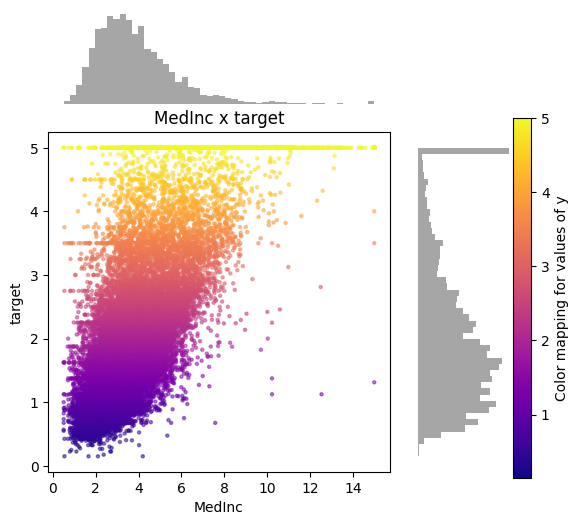

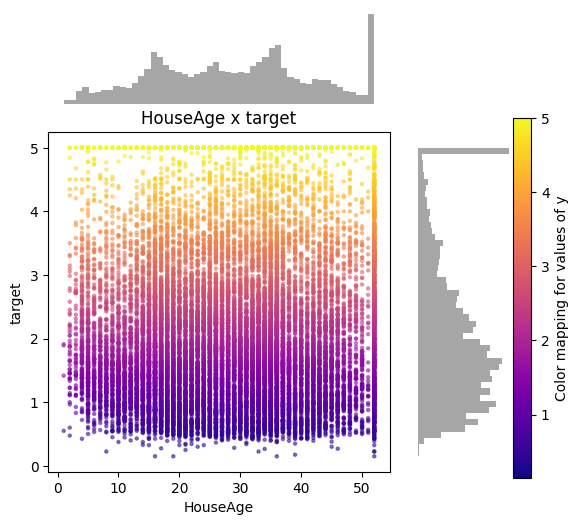

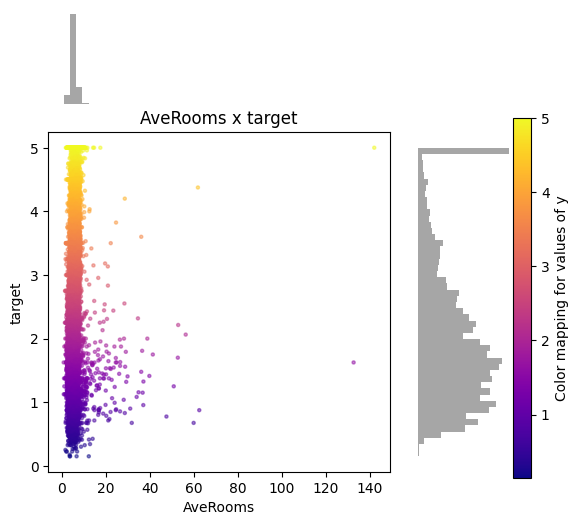

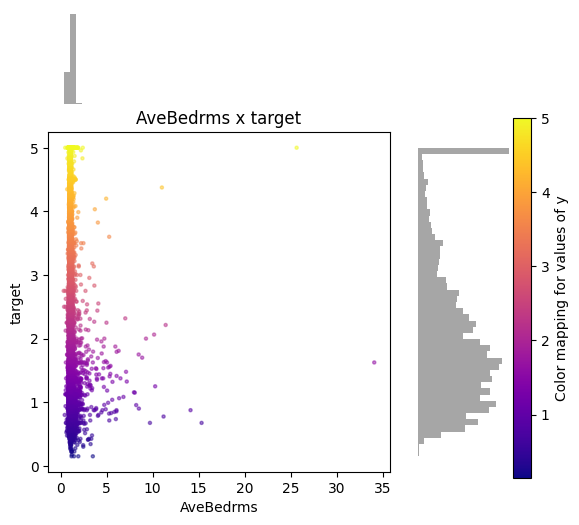

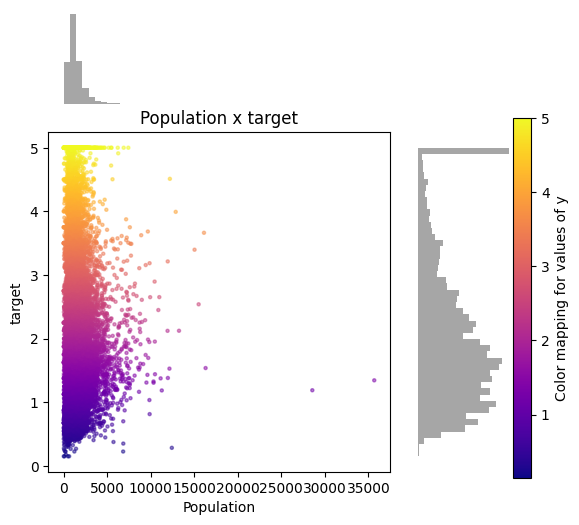

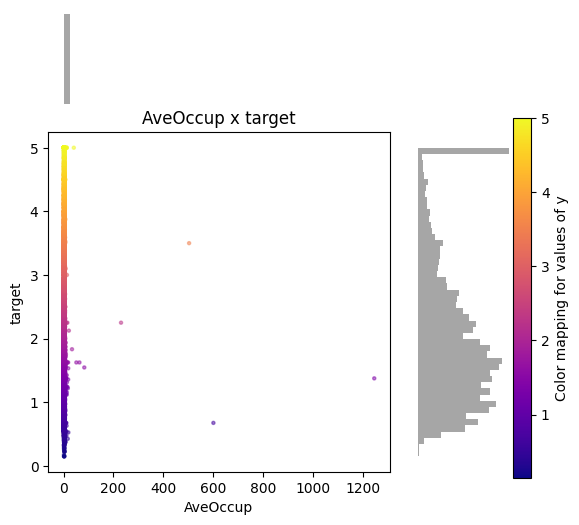

In [15]:
for feature_name in feature_names[:-2]:
  make_plot(feature_name, X_full, y_full)

## Simple Linear regression with Torch



[Source](https://www.learnpytorch.io/01_pytorch_workflow/)

In [43]:
X_label = 'MedInc'
y_label = "Median House Value"
X_simple_reg, y_simple_reg = X_full[:, feature_names.index('MedInc')], y_full
X_simple_reg, y_simple_reg = X_simple_reg.reshape(-1, 1), y_simple_reg.reshape(-1, 1)

X_simple_reg_tranf = PowerTransformer(method="yeo-johnson")
y_simple_reg_tranf = MinMaxScaler()

X_simple_reg_tranf.fit(X_simple_reg)
y_simple_reg_tranf.fit(y_simple_reg)

X_transformed, y_transformed = X_simple_reg_tranf.transform(X_simple_reg), y_simple_reg_tranf.transform(y_simple_reg)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [45]:
class LinearModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.weights = nn.Parameter(torch.randn(size=(1,), dtype=torch.float), requires_grad=True)
    self.b = nn.Parameter(torch.randn(size=(1,), dtype=torch.float), requires_grad=True)


  def forward(self, X) -> torch.Tensor:
    return self.weights * X + self.b

In [46]:
torch.manual_seed(42)

In [47]:
model_0 = LinearModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [48]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('b', tensor([0.1288]))])

In [49]:
feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [50]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

In [52]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):

  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
  plt.xlabel(X_label)  # Replace with an appropriate label
  plt.ylabel(y_label)

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14});

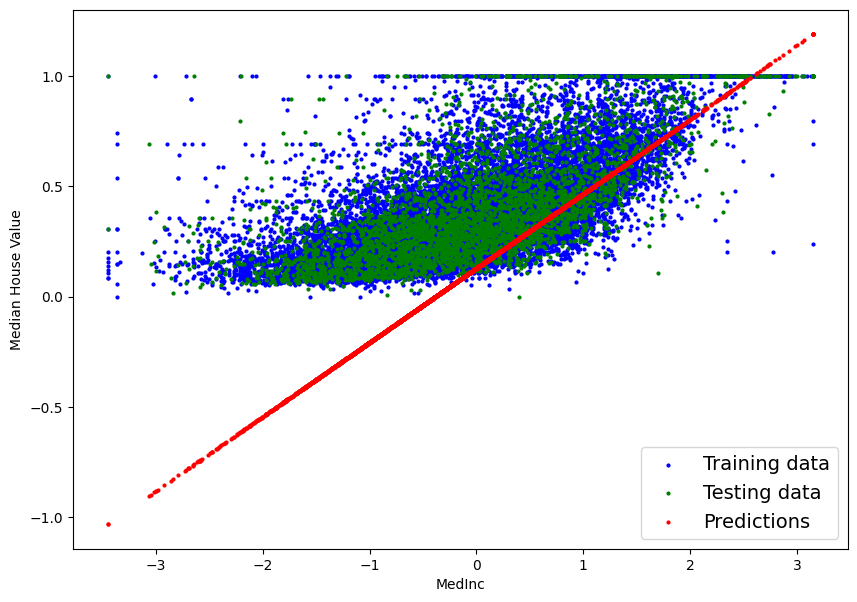

In [53]:
plot_predictions(predictions=y_preds)

### Training the model

In [103]:
def train_model(model, loss_func, optimizer, epochs, epoch_print_ratio=10):

  # Create empty loss lists to track values
  train_loss_values = []
  test_loss_values = []
  epoch_count = []


  for epoch in range(epochs):

    model.train() # Put model in training mode

    y_pred = model(X_train) # Forward pass the data
    loss = loss_func(y_pred, y_train.view(-1, 1)) # Calculate the loss

    optimizer.zero_grad() # Zero grad of the optimizer

    loss.backward() # Loss backwards

    optimizer.step() # Progress the optimizer


    ### Testing

    model.eval() # Put the model in evaluation mode


    with torch.inference_mode():
      test_pred = model(X_test)
      test_pred_loss = loss_func(test_pred, y_test.view(-1, 1))

      if epoch % epoch_print_ratio == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_pred_loss.detach().numpy())
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_pred_loss}")


  return epoch_count, train_loss_values, test_loss_values

In [55]:
model_0 = LinearModel()
loss_func = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

epoch_count, train_loss_values, test_loss_values = train_model(model_0, loss_func, optimizer, epochs=250)

Epoch: 0 | Loss: 0.19298578798770905 | Test loss: 0.18976694345474243
Epoch: 10 | Loss: 0.16012385487556458 | Test loss: 0.15812145173549652
Epoch: 20 | Loss: 0.1438475102186203 | Test loss: 0.14280661940574646
Epoch: 30 | Loss: 0.1372949182987213 | Test loss: 0.13658100366592407
Epoch: 40 | Loss: 0.13494716584682465 | Test loss: 0.1343478113412857
Epoch: 50 | Loss: 0.13421274721622467 | Test loss: 0.13363954424858093
Epoch: 60 | Loss: 0.13401685655117035 | Test loss: 0.13345162570476532
Epoch: 70 | Loss: 0.13396739959716797 | Test loss: 0.13339707255363464
Epoch: 80 | Loss: 0.13395217061042786 | Test loss: 0.13338519632816315
Epoch: 90 | Loss: 0.13394759595394135 | Test loss: 0.1333819180727005
Epoch: 100 | Loss: 0.1339467465877533 | Test loss: 0.13338130712509155
Epoch: 110 | Loss: 0.13394653797149658 | Test loss: 0.13338099420070648
Epoch: 120 | Loss: 0.13394643366336823 | Test loss: 0.1333807110786438
Epoch: 130 | Loss: 0.13394641876220703 | Test loss: 0.13338059186935425
Epoch: 14

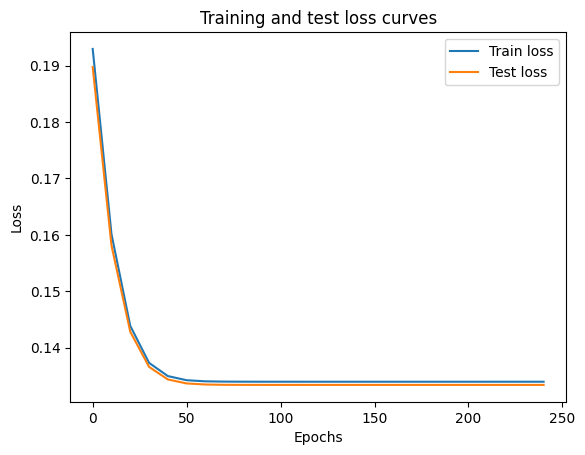

In [56]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

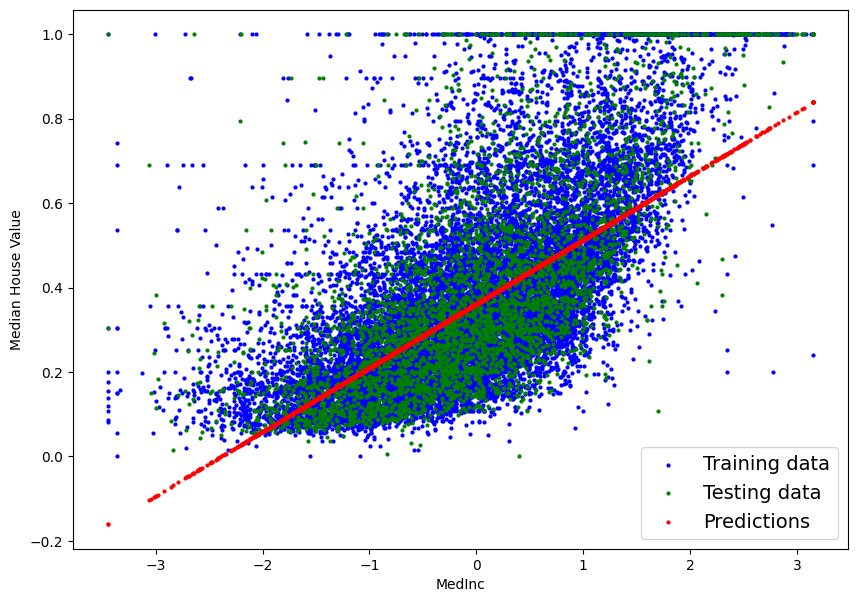

In [57]:
y_preds = model_0(X_test).cpu().detach().numpy()
plot_predictions(predictions=y_preds)

In [61]:
print(f"Slope: {np.round(model_0.weights.item(), 4)}")
print(f"Intercept: {np.round(model_0.b.item(), 4)}")

Slope: 0.1515
Intercept: 0.3617


In [121]:
class PolynomialLinearModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.a1 = nn.Parameter(torch.randn(size=(1,), dtype=torch.float), requires_grad=True)
    self.a2 = nn.Parameter(torch.randn(size=(1,), dtype=torch.float), requires_grad=True)
    self.a3 = nn.Parameter(torch.randn(size=(1,), dtype=torch.float), requires_grad=True)
    self.b = nn.Parameter(torch.randn(size=(1,), dtype=torch.float), requires_grad=True)


  def forward(self, X) -> torch.Tensor:
    return    self.a3 * torch.float_power(X, 3) + \
              self.a2 * torch.float_power(X, 2) + \
              self.a1 * X + \
              self.b

Epoch: 0 | Loss: 2.568074911194227 | Test loss: 2.487824334980714
Epoch: 100 | Loss: 2.3672035736932346 | Test loss: 2.28915084692927
Epoch: 200 | Loss: 2.1666849366523127 | Test loss: 2.0906975652281283
Epoch: 300 | Loss: 1.9702937851731455 | Test loss: 1.8954698062734243
Epoch: 400 | Loss: 1.7856346692897922 | Test loss: 1.7128824569978942
Epoch: 500 | Loss: 1.6372116150946527 | Test loss: 1.5682646853847246
Epoch: 600 | Loss: 1.5199902156131608 | Test loss: 1.4550969996171024
Epoch: 700 | Loss: 1.4191117280220373 | Test loss: 1.3590069165906196
Epoch: 800 | Loss: 1.326844195315091 | Test loss: 1.272194616131662
Epoch: 900 | Loss: 1.241289713583671 | Test loss: 1.1909617035694036
Epoch: 1000 | Loss: 1.1589121824673316 | Test loss: 1.1122852665818788
Epoch: 1100 | Loss: 1.0782083112140748 | Test loss: 1.0351084189458841
Epoch: 1200 | Loss: 0.9987676714892862 | Test loss: 0.959279881476326
Epoch: 1300 | Loss: 0.920593624942264 | Test loss: 0.8846880841924024
Epoch: 1400 | Loss: 0.84351

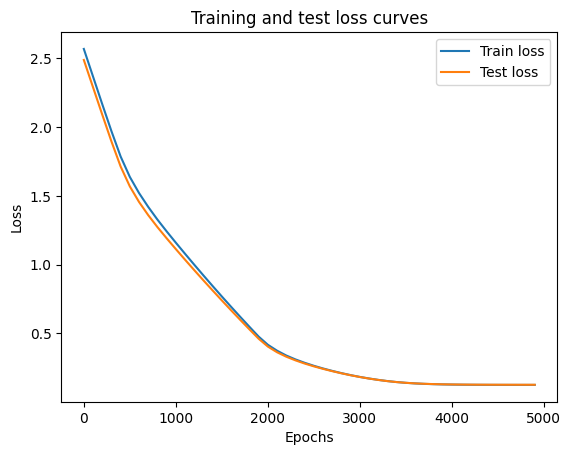

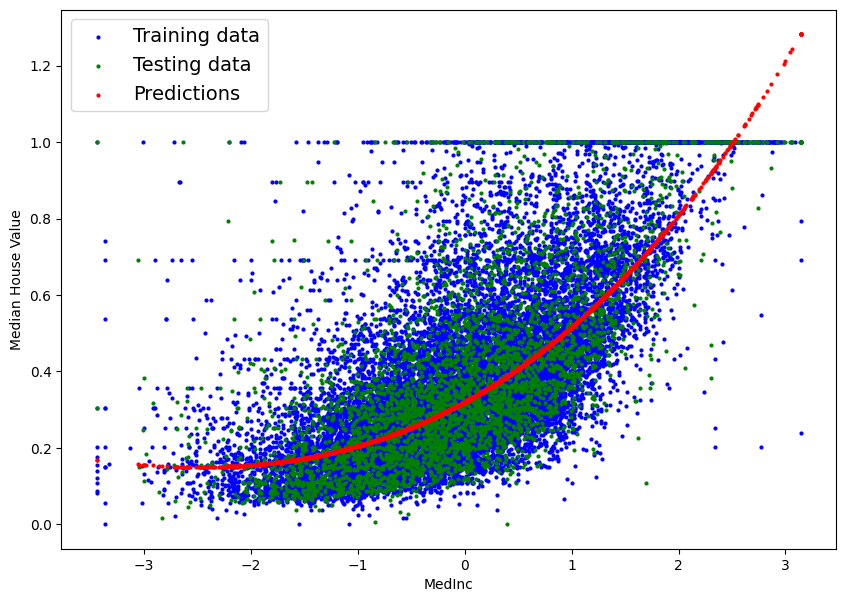

In [122]:
model_Poly = PolynomialLinearModel()
loss_func = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_Poly.parameters(), lr=0.001)

epoch_count, train_loss_values, test_loss_values = train_model(model_Poly, loss_func, optimizer, epochs=5000, epoch_print_ratio=100)

# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

y_preds = model_Poly(X_test).cpu().detach().numpy()
plot_predictions(predictions=y_preds)

In [129]:
def test_linear_neural_network_by_number_of_weights(n_weights=1, model_type=None):

  model_1 = model_type(n_weights)
  loss_func = nn.L1Loss()
  optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

  epoch_count, train_loss_values, test_loss_values = train_model(model_1, loss_func, optimizer, epochs=200)

  # Plot the loss curves
  plt.plot(epoch_count, train_loss_values, label="Train loss")
  plt.plot(epoch_count, test_loss_values, label="Test loss")
  plt.title("Training and test loss curves")
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  y_preds = model_1(X_test).cpu().detach().numpy()
  plot_predictions(predictions=y_preds)

In [130]:
class LinearNeuralNetwork(nn.Module):
  def __init__(self, n_weights=1):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=1, out_features=n_weights)
    self.layer_2 = nn.Linear(in_features=n_weights, out_features=1)

  def forward(self, X):
    x = F.relu(self.layer_1(X))
    x = self.layer_2(x)
    return x

Epoch: 0 | Loss: 0.4406685531139374 | Test loss: 0.4003526270389557
Epoch: 10 | Loss: 0.15524715185165405 | Test loss: 0.1467779278755188
Epoch: 20 | Loss: 0.129191055893898 | Test loss: 0.1292974203824997
Epoch: 30 | Loss: 0.12708792090415955 | Test loss: 0.12780655920505524
Epoch: 40 | Loss: 0.12640319764614105 | Test loss: 0.12732577323913574
Epoch: 50 | Loss: 0.12615516781806946 | Test loss: 0.1271454244852066
Epoch: 60 | Loss: 0.12596698105335236 | Test loss: 0.12701646983623505
Epoch: 70 | Loss: 0.1258094757795334 | Test loss: 0.12691089510917664
Epoch: 80 | Loss: 0.1256735622882843 | Test loss: 0.12682165205478668
Epoch: 90 | Loss: 0.12555918097496033 | Test loss: 0.12674830853939056
Epoch: 100 | Loss: 0.1254682093858719 | Test loss: 0.12668336927890778
Epoch: 110 | Loss: 0.12539009749889374 | Test loss: 0.12662667036056519
Epoch: 120 | Loss: 0.12531928718090057 | Test loss: 0.12657280266284943
Epoch: 130 | Loss: 0.1252564787864685 | Test loss: 0.12652181088924408
Epoch: 140 | L

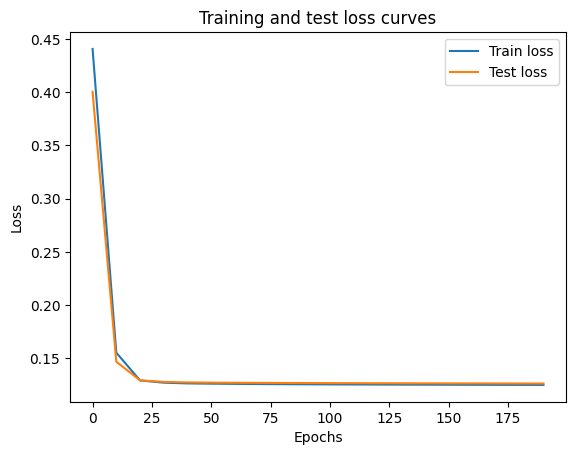

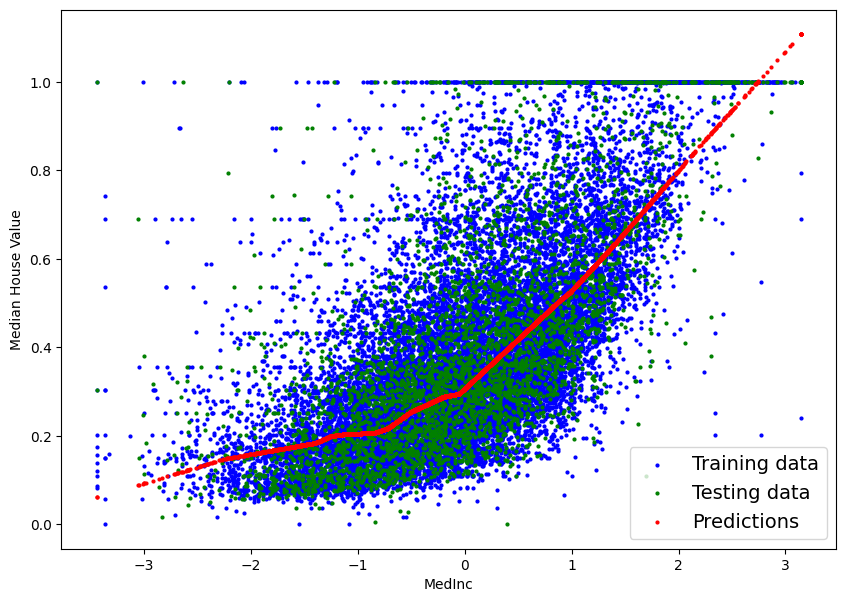

In [131]:
test_linear_neural_network_by_number_of_weights(n_weights=20, model_type = LinearNeuralNetwork)

Epoch: 0 | Loss: 0.49213895201683044 | Test loss: 0.30441465973854065
Epoch: 10 | Loss: 0.12969206273555756 | Test loss: 0.13142387568950653
Epoch: 20 | Loss: 0.1253904551267624 | Test loss: 0.12729844450950623
Epoch: 30 | Loss: 0.12448333203792572 | Test loss: 0.12629790604114532
Epoch: 40 | Loss: 0.12427198141813278 | Test loss: 0.12599559128284454
Epoch: 50 | Loss: 0.12418065220117569 | Test loss: 0.1258491724729538
Epoch: 60 | Loss: 0.1241232380270958 | Test loss: 0.12575626373291016
Epoch: 70 | Loss: 0.12408015877008438 | Test loss: 0.12569430470466614
Epoch: 80 | Loss: 0.12404276430606842 | Test loss: 0.12564441561698914
Epoch: 90 | Loss: 0.12401177734136581 | Test loss: 0.12560538947582245
Epoch: 100 | Loss: 0.12398581951856613 | Test loss: 0.12557202577590942
Epoch: 110 | Loss: 0.12396318465471268 | Test loss: 0.12554308772087097
Epoch: 120 | Loss: 0.12394285202026367 | Test loss: 0.1255158931016922
Epoch: 130 | Loss: 0.12392537295818329 | Test loss: 0.12549318373203278
Epoch: 

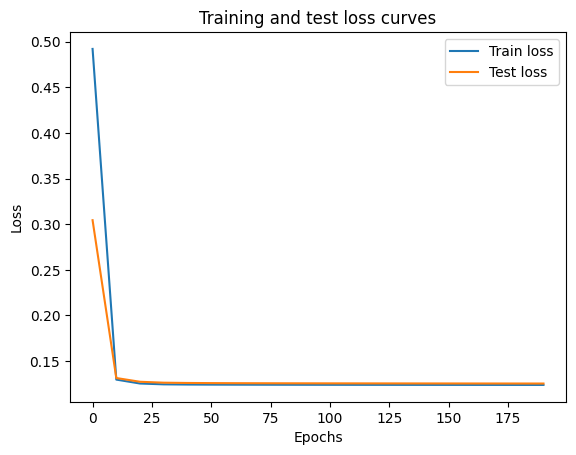

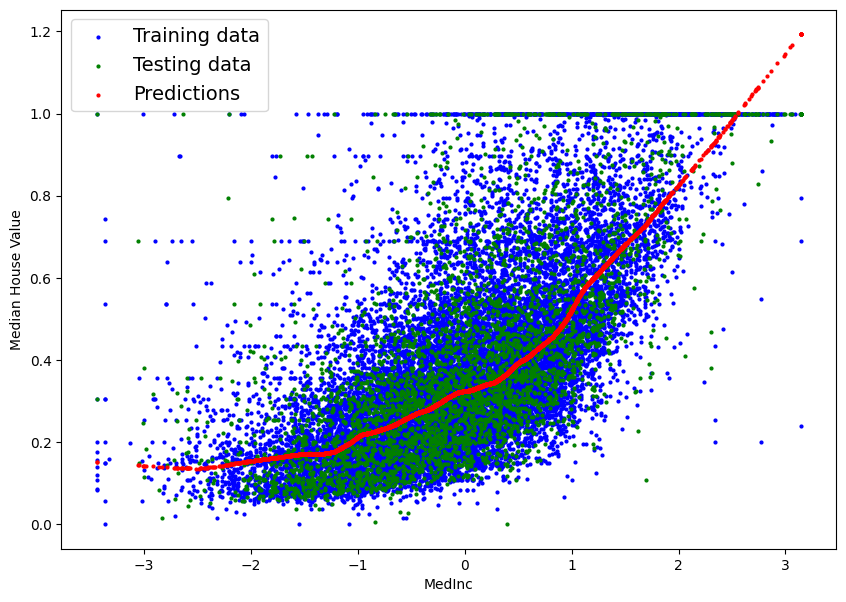

In [132]:
test_linear_neural_network_by_number_of_weights(n_weights=100, model_type = LinearNeuralNetwork)

In [37]:
## Adding a second layer
class LinearNeuralNetwork2(nn.Module):
  def __init__(self, n_weights=1):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=1, out_features=n_weights)
    self.layer_2 = nn.Linear(in_features=n_weights, out_features=max(int(n_weights/2), 1))
    self.layer_3 = nn.Linear(in_features=max(int(n_weights/2), 1), out_features=1)

  def forward(self, X):
    x = F.relu(self.layer_1(X))
    x = F.relu(self.layer_2(x))
    x = self.layer_3(x)
    return x

Epoch: 0 | Loss: 0.5080792903900146 | Test loss: 0.4808958172798157
Epoch: 10 | Loss: 0.34391894936561584 | Test loss: 0.32599905133247375
Epoch: 20 | Loss: 0.2667403817176819 | Test loss: 0.2564152777194977
Epoch: 30 | Loss: 0.22910287976264954 | Test loss: 0.22202865779399872
Epoch: 40 | Loss: 0.208155557513237 | Test loss: 0.20285367965698242
Epoch: 50 | Loss: 0.19400820136070251 | Test loss: 0.18978314101696014
Epoch: 60 | Loss: 0.18283188343048096 | Test loss: 0.17938487231731415
Epoch: 70 | Loss: 0.17300103604793549 | Test loss: 0.1701996773481369
Epoch: 80 | Loss: 0.1638709306716919 | Test loss: 0.1615799069404602
Epoch: 90 | Loss: 0.15550309419631958 | Test loss: 0.15370163321495056
Epoch: 100 | Loss: 0.14805126190185547 | Test loss: 0.14671921730041504
Epoch: 110 | Loss: 0.14167386293411255 | Test loss: 0.14088520407676697
Epoch: 120 | Loss: 0.13656869530677795 | Test loss: 0.13637560606002808
Epoch: 130 | Loss: 0.13267767429351807 | Test loss: 0.133015975356102
Epoch: 140 | L

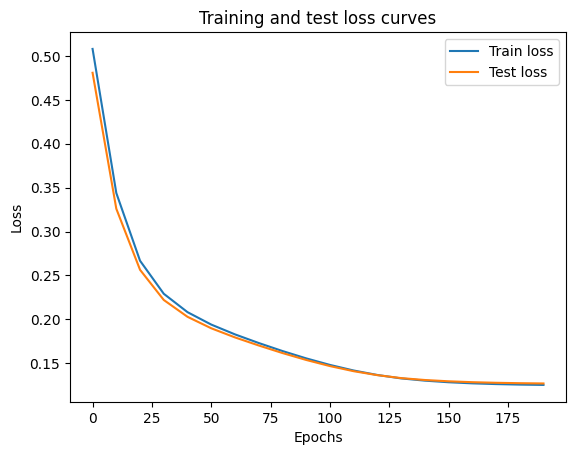

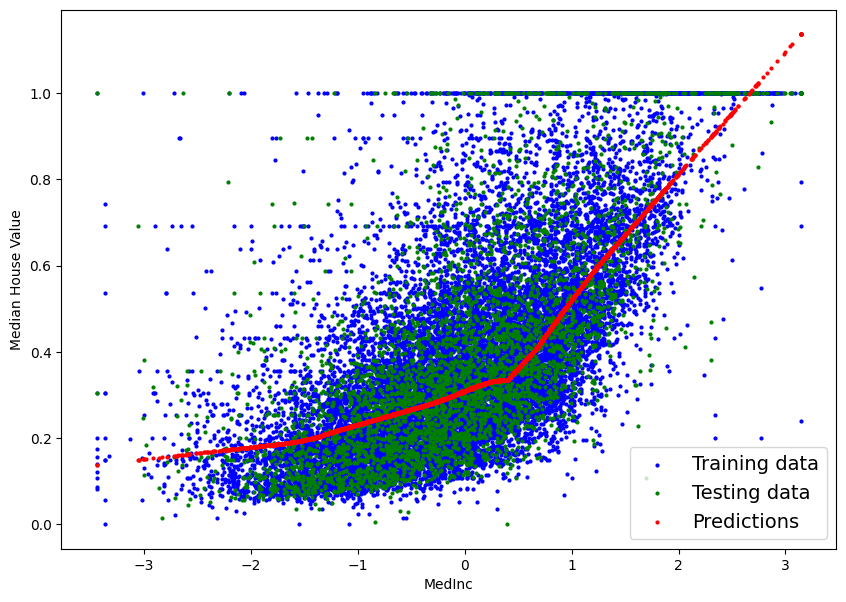

In [133]:
test_linear_neural_network_by_number_of_weights(n_weights=20, model_type = LinearNeuralNetwork2)

In [136]:
## Adding a second layer
class LinearNeuralNetwork3(nn.Module):
  def __init__(self, n_weights=1):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=1, out_features=10)
    self.layer_2 =  nn.Linear(in_features=10, out_features=5)
    self.layer_3 =  nn.Linear(in_features=5, out_features=1)

  def forward(self, X):
    x = F.relu(self.layer_1(X))
    x = F.tanh(self.layer_2(x))
    x = self.layer_3(x)
    return x

Epoch: 0 | Loss: 0.23327016830444336 | Test loss: 0.22461935877799988
Epoch: 10 | Loss: 0.19175365567207336 | Test loss: 0.1866251826286316
Epoch: 20 | Loss: 0.1710001528263092 | Test loss: 0.16749988496303558
Epoch: 30 | Loss: 0.15799742937088013 | Test loss: 0.15538856387138367
Epoch: 40 | Loss: 0.1487710326910019 | Test loss: 0.14685660600662231
Epoch: 50 | Loss: 0.14224620163440704 | Test loss: 0.1408642828464508
Epoch: 60 | Loss: 0.13771170377731323 | Test loss: 0.1368372142314911
Epoch: 70 | Loss: 0.13469985127449036 | Test loss: 0.13425521552562714
Epoch: 80 | Loss: 0.13279324769973755 | Test loss: 0.13264784216880798
Epoch: 90 | Loss: 0.1315796822309494 | Test loss: 0.13160859048366547
Epoch: 100 | Loss: 0.13075801730155945 | Test loss: 0.1309046447277069
Epoch: 110 | Loss: 0.13014793395996094 | Test loss: 0.13038881123065948
Epoch: 120 | Loss: 0.12965470552444458 | Test loss: 0.12999209761619568
Epoch: 130 | Loss: 0.12923869490623474 | Test loss: 0.12966471910476685
Epoch: 140

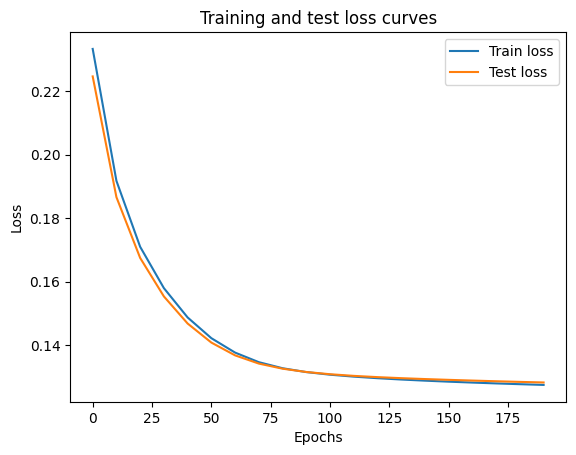

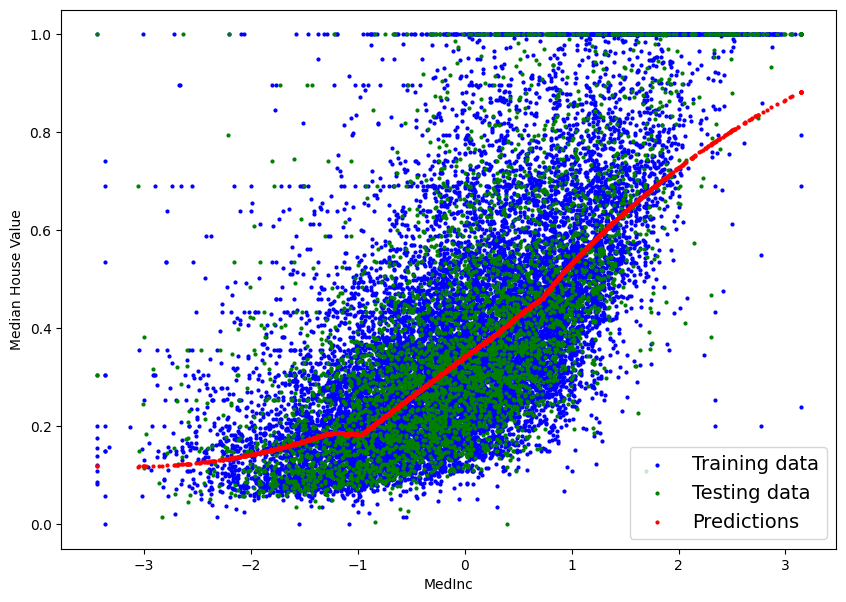

In [137]:
test_linear_neural_network_by_number_of_weights(n_weights=100, model_type = LinearNeuralNetwork3)